# Кластеризация. Практика. 

Кажется, что задача "поиска похожих групп объектов" довольно игрушечная, давайте покажем, что это не так! 

Рассмотрим задачу рекомендации фильмов. Данные о рейтинге фильмов можно скачать тут: 
https://cloud.mail.ru/public/CSjR/mPctRVc2u

In [10]:
import pandas as pd
from matplotlib import pyplot as plt
from wordcloud import WordCloud
from matplotlib.pyplot import figure

In [11]:
data = pd.read_csv('user_ratedmovies.dat', sep='\t')
data.head()

,userID,movieID,rating,date_day,date_month,date_year,date_hour,date_minute,date_second
0,75,3,1.0,29,10,2006,23,17,16
1,75,32,4.5,29,10,2006,23,23,44
2,75,110,4.0,29,10,2006,23,30,8
3,75,160,2.0,29,10,2006,23,16,52
4,75,163,4.0,29,10,2006,23,29,30


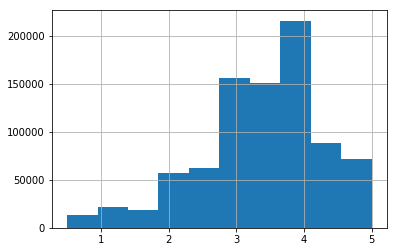

In [12]:
data['rating'].hist()
plt.show()

 Есть 2 разновидности обучения рекомендательных систем: 
 
 1) explicit feedback -- пользователь ставит оценку объекту
 
 2) implicit feedback -- мы понимаем, понравился объект или не понравится по неявному взаимодействию пользователя с выдачей
 


Для explicit feedback совершенно понятно, как собирать датасет и учить модель - берем все пары (человек, фильм), для которых у нас есть оценки, учим на них модель, предсказываем оценки для неизвестных пар (человек, фильм). Как, кстати, валидировать?

Для implicit feedback позивной парой (пользователь, фильм) будут просто фильмы которые просмотрел этот пользователь. А что с негативными?

Какие у каждого подхода плюсы и минусы?

Давайте не будем мучиться с майнингом негативных примеров (что, вообще говоря, довольно сложная задача, про нее целые статьи пишутся). 
Посмотрим можно ли методами кластеризации предсказать, что ппорекомендовать человеку посмотреть.

In [13]:
liked_data = data[data.rating >= 3]
print (liked_data.shape)

(682605, 9)


In [14]:
users = list(liked_data['userID'])
movies = list(liked_data['movieID'])

Возьмем все фильмы, которые смотрел каждый пользователь. Базовая гипотеза --  фильмы, которые  смотрят вместе одни люди скорее будут в одном кластере, чем в разных.  

In [15]:
user2movies = {}
for i in range(len(users)):
    user_id = users[i]
    movie_id = movies[i]
    if user_id not in user2movies:
        user2movies[user_id] = set()
    user2movies[user_id].add(movie_id)

### Pointwise mutual information 
Часто используемая мера связи между категориальными признаками. 
$$PMI(x,y) = \log \frac{p(x,y)}{p(x) p(y)} $$
В дискретном случае, если всего $N$ событий и мы хотим посчитать вероятность, что $x, y$ встретились вместе:
$$PMI(x,y) = \log \frac{n_{x,y}  N}{n_x, n_y}, $$
где $n_x - $ число событий где встретилось $x$,  $n_y - $ число событий где встретилось $y, n_{x,y} - $ число событий где встретились вместе $x$ и $y$, $N$ - общее число событий

In [16]:
pairs_count = {}
movies_count = {}
for k, new_user in enumerate(user2movies):
    movies = list(user2movies[new_user])
    for i in range(len(movies)):
        i_movie = movies[i]
        if i_movie not in movies_count:
            movies_count[i_movie] = 0
        movies_count[i_movie] += 1
        for j in range(i + 1, len(movies)):
            j_movie = movies[j]
            assert (i_movie != j_movie)
            if i_movie < j_movie:
                pair = (i_movie, j_movie)
            else:
                pair = (j_movie, i_movie)
            if pair not in pairs_count:
                pairs_count[pair] = 0
            pairs_count[pair] += 1

найдем похожие фильмы на мой любимый по PMI!

In [11]:
movies_data = pd.read_csv('movies.dat', sep='\t',  encoding = "ISO-8859-1")
movies_data[movies_data.id == 1 ]

,id,title,imdbID,spanishTitle,imdbPictureURL,year,rtID,rtAllCriticsRating,rtAllCriticsNumReviews,rtAllCriticsNumFresh,...,rtAllCriticsScore,rtTopCriticsRating,rtTopCriticsNumReviews,rtTopCriticsNumFresh,rtTopCriticsNumRotten,rtTopCriticsScore,rtAudienceRating,rtAudienceNumRatings,rtAudienceScore,rtPictureURL
0,1,Toy story,114709,Toy story (juguetes),http://ia.media-imdb.com/images/M/MV5BMTMwNDU0...,1995,toy_story,9,73,73,...,100,8.5,17,17,0,100,3.7,102338,81,http://content7.flixster.com/movie/10/93/63/10...


In [12]:
scores = []
REG_THR = 300
for i in pairs_count:
    if pairs_count[i] < REG_THR:
        continue
    score = pairs_count[i] / (movies_count[i[0]] * movies_count[i[1]])
    if i[0] == 1:
        scores.append((score, i[1]))
top_sim_docs = [i[1] for i in sorted(scores, reverse=True)][0:30]

In [13]:
all_words = ""
for i in top_sim_docs:
    new_tile = movies_data[movies_data.id == i ].title.values[0]
    print (new_tile)
    all_words += " " + movies_data[movies_data.id == i ].title.values[0]

Toy Story
A Bug's Life
The Little Mermaid
Snow White and the Seven Dwarfs
Honey, I Shrunk the Kids
Beauty and the Beast
The Lost World: Jurassic Park
Babe
Mary Poppins
Antz
Aladdin
Bill & Ted's Excellent Adventure
Jumanji
Batman Returns
The Lion King
Galaxy Quest
Happy Gilmore
Legally Blonde
A League of Their Own
Batman Forever
Field of Dreams
Clear and Present Danger
Wayne's World
Air Force One
The Wizard of Oz
Fantasia
Twister
Chicken Run
Signs
Home Alone


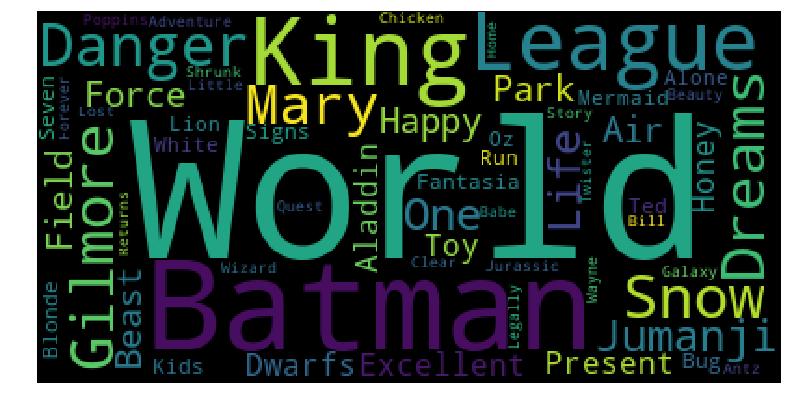

In [14]:
wordcloud = WordCloud().generate(all_words)
figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Ваша модель из домашки сможет сделать лучше!

А если прмиенить такую же схему к вообще другим данным? Например, к текстам!

In [3]:
doc2words = {}
with open('docs_titles.tsv') as f:
    for num_line, line in enumerate(f):
        if num_line == 0:
            continue
        data = line.strip().split('\t', 1)
        doc_id = int(data[0])
        if len(data) == 1:
            title = ''
        else:
            title = data[1]
        doc2words[doc_id] = set(title.strip().lower().split())
print(len(doc2words))

28026


Разумно считать PMI по окнам некоторой ширины, но мы забьем и просто посчитаем по заголовкам. 

In [4]:
pairs_count = {}
word_count = {}
for k, new_doc in enumerate(doc2words):
    if k % 10000 == 0:
        print (k)
    words = list(doc2words[new_doc])
    for i in range(len(words)):
        i_word = words[i]
        if i_word not in word_count:
            word_count[i_word] = 0
        word_count[i_word] += 1
        for j in range(i + 1, len(words)):
            j_word = words[j]
            assert (i_word != j_word)
            if i_word < j_word:
                pair = (i_word, j_word)
            else:
                pair = (j_word, i_word)
            if pair not in pairs_count:
                pairs_count[pair] = 0
            pairs_count[pair] += 1

0
10000
20000


In [5]:
# Какое коварное слово, мухахаха
test_word = '1.6'
scores = []
REG_THR = 3
REG_THR_2 = 0.001
for i in pairs_count:
    if pairs_count[i] < REG_THR:
        continue
    score = pairs_count[i] / (word_count[i[0]] * word_count[i[1]])
    if score < REG_THR_2:
        continue
    if i[0] == test_word:
        scores.append((score, i[1]))
    if i[1] == test_word:
        scores.append((score, i[0]))

In [6]:
top_sim_docs = [i[1] for i in sorted(scores, reverse=True)][0:20]

In [7]:
all_words = ""
for i in top_sim_docs:
    all_words += " " + i

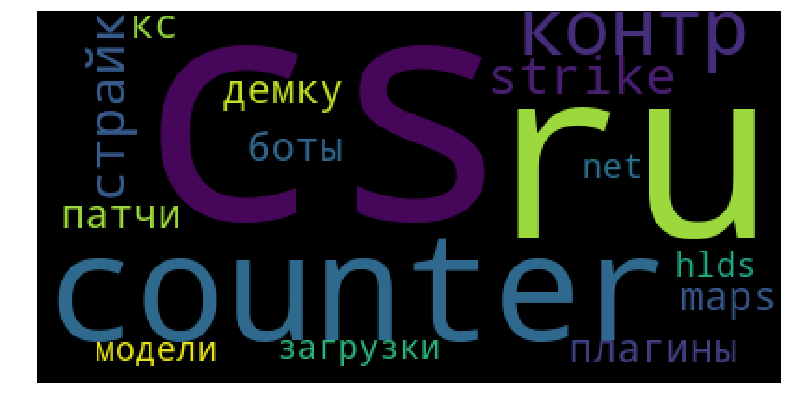

In [9]:
wordcloud = WordCloud().generate(all_words)
figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Какие Вы видите применения таких кластеров? В проекте? В других задачах?